<a href="https://colab.research.google.com/github/tomonari-masada/courses/blob/master/SML2020/08_solubility_revised.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# (revised version) ケーススタディ： solubility data

Max Kuhn and Kjell Johnson. Applied Predictive Modeling. Springer, 2013. に出てくるデータセット (Section 6.1)

http://appliedpredictivemodeling.com/data

* 説明変数は下記の228個
 * Two hundred and eight binary “fingerprints” that indicate the presence or absence of a particular chemical substructure.
 * Sixteen count descriptors, such as the number of bonds or the number of bromine atoms.
 * Four continuous descriptors, such as molecular weight or surface area.

* 目的変数はlog solubility
 * 範囲は−11.6 to 1.6、平均は−2.7

### 1) 訓練データとテストデータを読む

In [1]:
import numpy as np
import pandas as pd

In [2]:
X_train = pd.read_csv('solTrainX.csv')
y_train = pd.read_csv('solTrainY.csv')['x']

X_test = pd.read_csv('solTestX.csv')
y_test = pd.read_csv('solTestY.csv')['x']

### 2) 連続値をとる20変数の様子をみる

* seabornで散布図を描く。
* もちろん訓練データを使う。
* 縦軸は目的変数とする。

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
# 連続値をとる変数の名前を取り出す

continuous = [s for s in X_train.columns.to_list()
  if s[:3] == 'Num' or s[:3] == 'Hyd' or s[:3] == 'Mol' or s[:3] == 'Sur']
print(len(continuous), continuous)

20 ['MolWeight', 'NumAtoms', 'NumNonHAtoms', 'NumBonds', 'NumNonHBonds', 'NumMultBonds', 'NumRotBonds', 'NumDblBonds', 'NumAromaticBonds', 'NumHydrogen', 'NumCarbon', 'NumNitrogen', 'NumOxygen', 'NumSulfer', 'NumChlorine', 'NumHalogen', 'NumRings', 'HydrophilicFactor', 'SurfaceArea1', 'SurfaceArea2']


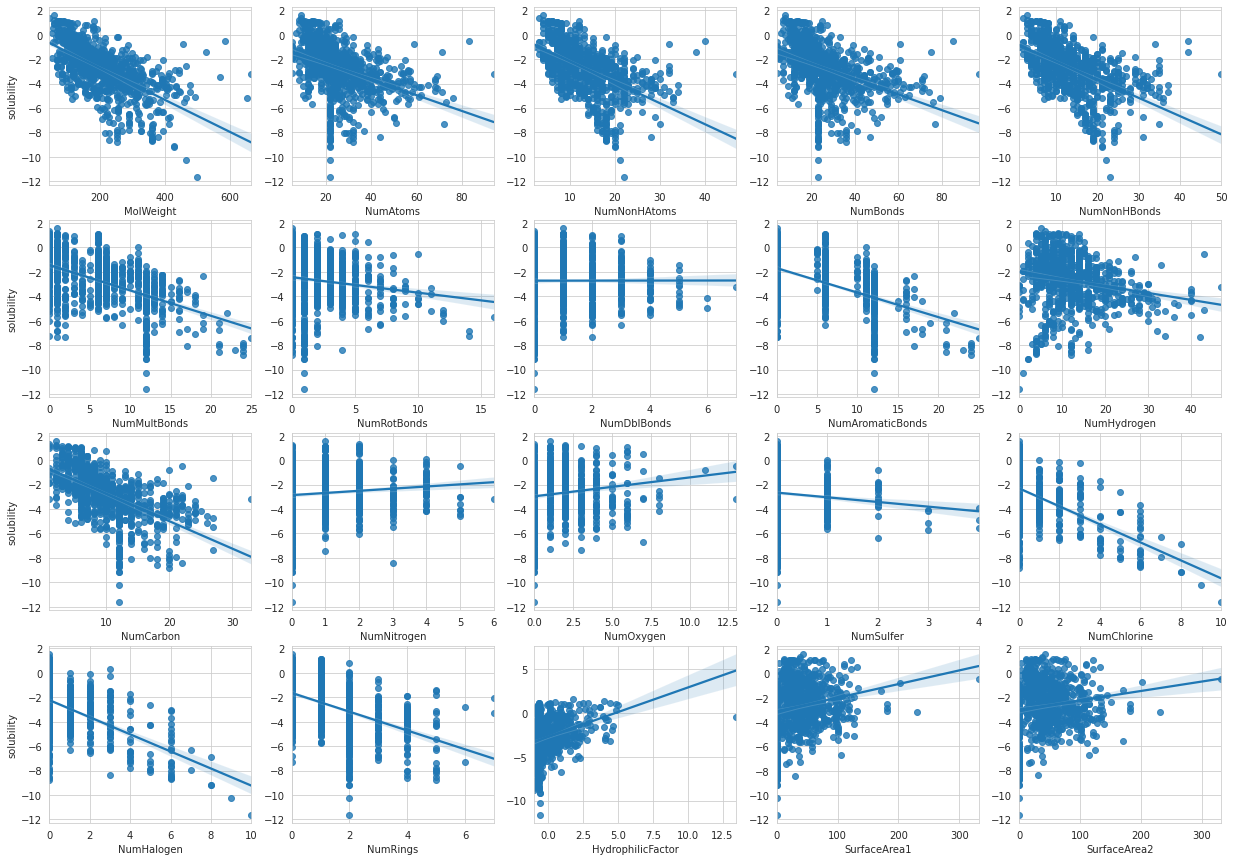

In [5]:
X_train['solubility'] = y_train # 図を描くために、一時的にこうしておく

sns.set_style("whitegrid")
fig = plt.figure(figsize=(21.0, 15.0))
for i in range(20):
  ax = fig.add_subplot(4, 5, i+1)
  sns.regplot(x=continuous[i], y='solubility', data=X_train, ax=ax)
  if i % 5 != 0: ax.set_ylabel('')

X_train = X_train.drop('solubility', axis=1) # 図を描き終えたので、元に戻す

### 3) ２値変数の部分の雰囲気を見る

In [6]:
binary = X_train.columns[X_train.columns.str.startswith('FP')].to_list()
print(len(binary))
X_train[binary].describe()

208


,FP001,FP002,FP003,FP004,FP005,FP006,FP007,FP008,FP009,FP010,FP011,FP012,FP013,FP014,FP015,FP016,FP017,FP018,FP019,FP020,FP021,FP022,FP023,FP024,FP025,FP026,FP027,FP028,FP029,FP030,FP031,FP032,FP033,FP034,FP035,FP036,FP037,FP038,FP039,FP040,...,FP169,FP170,FP171,FP172,FP173,FP174,FP175,FP176,FP177,FP178,FP179,FP180,FP181,FP182,FP183,FP184,FP185,FP186,FP187,FP188,FP189,FP190,FP191,FP192,FP193,FP194,FP195,FP196,FP197,FP198,FP199,FP200,FP201,FP202,FP203,FP204,FP205,FP206,FP207,FP208
count,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,...,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000
mean,0.493165,0.539432,0.436383,0.584648,0.579390,0.400631,0.363828,0.325973,0.279706,0.178759,0.214511,0.176656,0.166141,0.160883,0.860147,0.146162,0.144059,0.131441,0.121977,0.119874,0.120925,0.104101,0.123028,0.112513,0.115668,0.084122,0.097792,0.106204,0.101998,0.093586,0.089380,0.073607,0.069401,0.079916,0.072555,0.075710,0.070452,0.086225,0.074658,0.068349,...,0.186120,0.184017,0.169295,0.151420,0.141956,0.130389,0.134595,0.121977,0.120925,0.120925,0.097792,0.107256,0.093586,0.098843,0.075710,0.084122,0.085174,0.076761,0.072555,0.068349,0.076761,0.072555,0.070452,0.060988,0.062040,0.058885,0.060988,0.056782,0.052576,0.056782,0.047319,0.049422,0.052576,0.257624,0.114616,0.098843,0.077813,0.059937,0.056782,0.112513
std,0.500216,0.498705,0.496197,0.493042,0.493917,0.490284,0.481353,0.468984,0.449091,0.383352,0.410699,0.381578,0.372403,0.367617,0.347017,0.353454,0.351334,0.338059,0.327431,0.324985,0.326212,0.305552,0.328643,0.316163,0.319994,0.277717,0.297189,0.308261,0.302805,0.291405,0.285441,0.261267,0.254268,0.271306,0.259541,0.264672,0.256042,0.280844,0.262977,0.252477,...,0.389408,0.387702,0.375210,0.358646,0.349188,0.336908,0.341470,0.327431,0.326212,0.326212,0.297189,0.309601,0.291405,0.298609,0.264672,0.277717,0.279287,0.266352,0.259541,0.252477,0.266352,0.259541,0.256042,0.239435,0.241355,0.235534,0.239435,0.231548,0.223303,0.231548,0.212431,0.216861,0.223303,0.437556,0.318726,0.298609,0.268018,0.237495,0.231548,0.316163
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,

### 4) 2値の部分と連続値の部分をあわせた元のデータに、単純に線形回帰を適用

* LinearRegression()はチューニングすべきハイパーパラメータをもっていない。
* だから、X_trainから検証データを切り出さずに、いきなりモデルを訓練している。

In [7]:
# 2値の説明変数と連続値の説明変数を連結して、訓練データ全体を作る

X_train = pd.concat([X_train[binary], X_train[continuous]], axis=1)

In [8]:
# 線形回帰モデルのパラメータを最小二乗法で推定させる

from sklearn.linear_model import LinearRegression

reg = LinearRegression()
reg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [9]:
# テストデータでの予測を評価する

from sklearn.metrics import mean_squared_error

X_test = pd.concat([X_test[binary], X_test[continuous]], axis=1)
y_test_pred = reg.predict(X_test)
print('RMSE:', mean_squared_error(y_test, y_test_pred, squared=False))

RMSE: 0.7968957706086087


この 0.797 という　RMSEを改善できるかどうか、いろいろ試行錯誤する。

---

（ここから試行錯誤してみてください。）

---

### 5) PCAを使って2値の部分だけ次元を落としてみる

In [10]:
from sklearn.decomposition import PCA

n_components = 100 # 使用する主成分の個数
pca = PCA(n_components=n_components, random_state=123) # random_stateは入れておいたほうがいいようだ。
pca.fit(X_train[binary])

PCA(copy=True, iterated_power='auto', n_components=100, random_state=123,
    svd_solver='auto', tol=0.0, whiten=False)

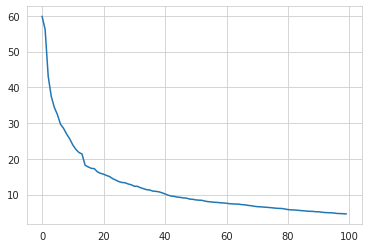

In [11]:
plt.plot(range(n_components), pca.singular_values_)

In [12]:
X_train_binary = X_train[binary]
X_train_binary_embedded = pca.transform(X_train_binary)

In [13]:
# 最初のレコードの次元削減バージョンを見てみる

X_train_binary_embedded[0]

array([ 1.45333496e+00, -1.44179928e+00, -1.07689363e+00,  1.49383011e+00,
        1.09059605e+00, -1.20846160e+00, -9.72704134e-01, -5.81835173e-02,
        1.08131028e-02,  1.50577481e+00, -9.01356617e-01, -9.33780869e-01,
        1.07081867e-01, -7.78480719e-01, -1.29601774e+00,  3.10016054e-01,
        6.58401410e-03,  2.40795996e-01,  1.51684572e-01,  1.01514571e-01,
        6.17768006e-01,  3.85365043e-01, -2.00713921e-01,  5.81726618e-01,
        2.46260723e-01, -3.30514564e-01,  2.55346484e-01,  3.00810864e-01,
       -6.33162461e-01,  8.89403038e-02,  3.52131353e-01,  2.05031390e-01,
        2.07769435e-01,  3.22645073e-01,  2.82149268e-01, -2.28486676e-01,
       -1.14513100e-01, -1.96917675e-01,  1.84364406e-01,  1.10950947e-01,
        1.84970825e-01,  3.54922085e-01, -1.49729381e-01,  7.61728941e-01,
        3.95943219e-02,  2.15381755e-01, -3.50263106e-01,  2.12741670e-02,
       -8.30112507e-02, -2.01718320e-01, -6.95096842e-02,  3.38151385e-01,
        2.60937086e-01, -

In [14]:
# 2値変数の部分を次元削減した後のものと、元の連続値の部分とを、くっつける

X_train_embedded = np.concatenate([X_train_binary_embedded, X_train[continuous]], 1)

In [15]:
# X_train_embeddedを使って回帰係数の推定をしてみる。
#　そしてテストデータでの予測スコアを求めてみる。
# （もちろん、テストデータの2値の部分も、次元削減する必要があります。）

reg = LinearRegression()
reg.fit(X_train_embedded, y_train)

X_test_binary_embedded = pca.transform(X_test[binary])
X_test_embedded = np.concatenate([X_test_binary_embedded, X_test[continuous]], 1)
y_test_pred = reg.predict(X_test_embedded)
print('RMSE:', mean_squared_error(y_test, y_test_pred, squared=False))

RMSE: 0.7932003808933763


ほんの少しだけ、良くなっている。

### 6) ２値変数のインタラクションを考慮してみる

* PolynomialFeaturesを2次の設定で使う
* その上で主成分分析を適用

In [16]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(2, interaction_only=True, include_bias=False)
poly.fit(X_train_binary)

PolynomialFeatures(degree=2, include_bias=False, interaction_only=True,
                   order='C')

In [17]:
X_train_binary_poly = poly.transform(X_train_binary)

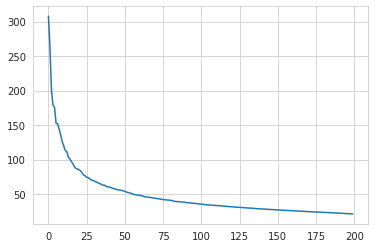

In [18]:
n_components = 200
pca = PCA(n_components=n_components, random_state=123) # random_stateは入れておいたほうがいいようだ。
pca.fit(X_train_binary_poly)
plt.plot(range(n_components), pca.singular_values_)

In [19]:
# 2次のインタラクションを含めた2値変数の部分を次元削減した後のものと、元の連続値の部分とを、くっつける

X_train_embedded = np.concatenate([pca.transform(X_train_binary_poly), X_train[continuous]], 1)

In [20]:
reg = LinearRegression()
reg.fit(X_train_embedded, y_train)

X_test_binary_poly_embedded = pca.transform(poly.transform(X_test[binary]))
X_test_embedded = np.concatenate([X_test_binary_poly_embedded, X_test[continuous]], 1)
y_test_pred = reg.predict(X_test_embedded)
print('RMSE:', mean_squared_error(y_test, y_test_pred, squared=False))

RMSE: 0.709126844577584


かなり良くなっている。

### 7) Ridge回帰を使う

* 検証セットを切り分けて、alphaをチューニングする。
* なぜなら、検証セットでの評価値を見て、alphaの設定の良し悪しを判断するためである。そのために検証セットを作る。

In [21]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.15, random_state=123)

In [22]:
from sklearn.linear_model import Ridge

for alpha in 10. ** np.arange(-5, 6):
  reg = Ridge(alpha=alpha)
  reg.fit(X_train, y_train)
  y_valid_pred = reg.predict(X_valid)
  print('alpha: {}; RMSE: {:.4f}'.format(alpha, mean_squared_error(y_valid, y_valid_pred, squared=False)))

alpha: 1e-05; RMSE: 0.6651
alpha: 0.0001; RMSE: 0.6651
alpha: 0.001; RMSE: 0.6649
alpha: 0.01; RMSE: 0.6634
alpha: 0.1; RMSE: 0.6512
alpha: 1.0; RMSE: 0.6148
alpha: 10.0; RMSE: 0.6296
alpha: 100.0; RMSE: 0.7441
alpha: 1000.0; RMSE: 0.9147
alpha: 10000.0; RMSE: 1.0650
alpha: 100000.0; RMSE: 1.1302


In [23]:
# R一番良かったalphaを使って、テストデータで最終評価

reg = Ridge(alpha=1.0)
reg.fit(X_train, y_train)

y_test_pred = reg.predict(X_test)
print('RMSE:', mean_squared_error(y_test, y_test_pred, squared=False))

RMSE: 0.7812124488525388


それほど良くはない。
検証データでの評価結果と大きな差があるようだ。

# 課題8
* solubilityデータセットのテストデータに対して、できるだけ予測性能の良いモデルを見つけよう
 * Ridge回帰やLassoを使ってもいいです。
 * 特徴量はどのように加工してもいいです。（上では2値変数にPCAを使った）
